# TITLE

## Objective
1. Load DICOM CT images and segmentations.
2. Visualize data and check alignment.
3. Create a MIP animation with tumor mask overlay.

In [1]:
# Execute this cell to make sure 
# that external modules are reloaded
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from skimage.measure import find_contours
from IPython.display import HTML
import time
import psutil

from utils import (
    load_ct_slices,
    load_segmentation,
    create_mip,
    overlay_mask,
    rotate_volume
)

%matplotlib inline
plt.style.use('grayscale')

In [3]:
CT_DIR     = "../dataset/10_AP_Ax2.50mm"
SEG_PATH   = "../dataset/10_AP_Ax2.50mm_ManualROI_Tumor.dcm"
OUTPUT_DIR = "output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Initialize benchmarking
metrics = {}
process = psutil.Process(os.getpid())

# Load CT volume (with acquisition check and timings)
t0 = time.perf_counter()
ct_volume, metadata, utils_metrics = load_ct_slices(CT_DIR)
t1 = time.perf_counter()
metrics.update(utils_metrics)
metrics['total_load_time'] = t1 - t0
metrics['memory_after_load'] = process.memory_info().rss

ct_positions = metadata['positions']
print(f"Single AcquisitionNumber: {metadata['acquisition_number']}")
print(f"CT Volume Shape: {ct_volume.shape}   Spacing (mm): {metadata['spacing']}")

# Load segmentation labels
t2 = time.perf_counter()
mask_volume = load_segmentation(SEG_PATH, ct_positions)
t3 = time.perf_counter()
metrics['segmentation_time'] = t3 - t2
metrics['memory_after_seg'] = process.memory_info().rss
print(f"Segmentation Label Volume Shape: {mask_volume.shape}")

Single AcquisitionNumber: -1
CT Volume Shape: (207, 512, 512)   Spacing (mm): (0.78125, 0.78125, 2.5)
Segmentation Label Volume Shape: (207, 512, 512)


## Data Verification

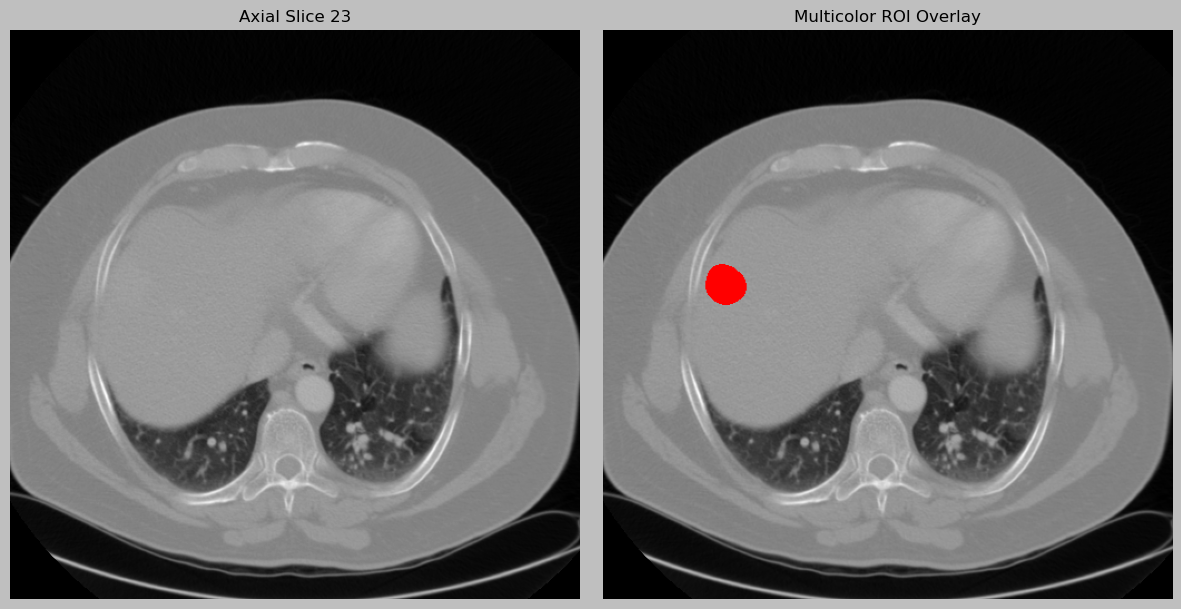

In [4]:
tumor_slices = np.where(mask_volume.sum(axis=(1,2)) > 0)[0]
slice_idx = tumor_slices[0]
ct_slice = ct_volume[slice_idx]
mask_slice = mask_volume[slice_idx]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(ct_slice, cmap='gray'); axes[0].axis('off'); axes[0].set_title(f"Axial Slice {slice_idx}")

axes[1].imshow(ct_slice, cmap='gray')
overlay = overlay_mask(ct_slice, mask_slice)
axes[1].imshow(overlay)
axes[1].axis('off'); axes[1].set_title("Multicolor ROI Overlay")

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "slice_multicolor_overlay.png"))
plt.show()

## Maximum Intensity Projection

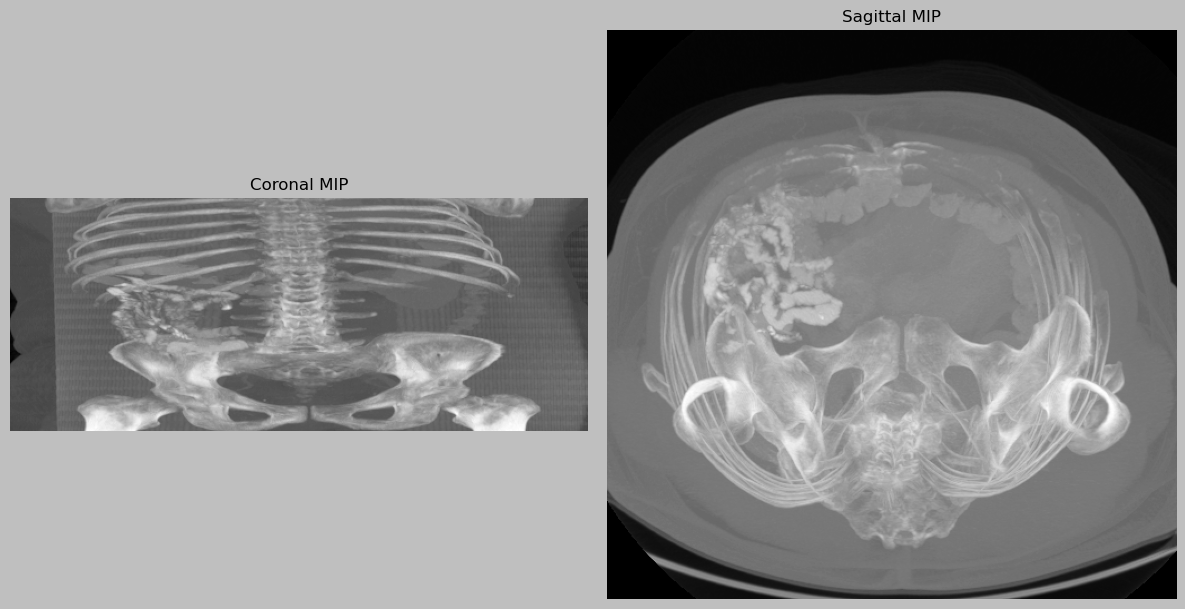

In [5]:
t4 = time.perf_counter()
mip_coronal  = create_mip(ct_volume, axis=1)
mip_sagittal = create_mip(ct_volume, axis=0)
t5 = time.perf_counter()
metrics['mip_time'] = t5 - t4
metrics['memory_after_mip'] = process.memory_info().rss

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(mip_coronal,  cmap='gray'); axes[0].axis('off'); axes[0].set_title("Coronal MIP")
axes[1].imshow(mip_sagittal, cmap='gray'); axes[1].axis('off'); axes[1].set_title("Sagittal MIP")
fig.tight_layout(); fig.savefig(os.path.join(OUTPUT_DIR, "mips.png")); plt.show()

## Rotating MIP Animation

Animation saved at output\mip_rotation.gif
Processing complete.


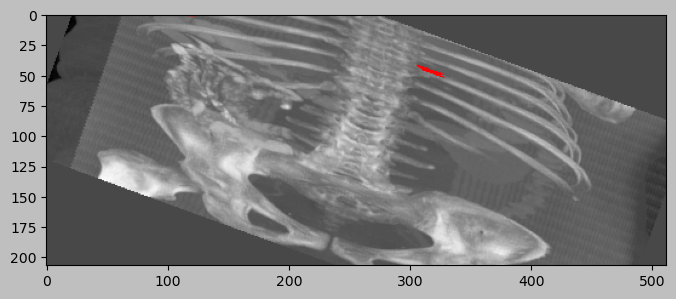

In [6]:
t6 = time.perf_counter()
n_frames = 18
fps      = 10
fig_anim = plt.figure(figsize=(8, 8))

def update(frame_idx):
    angle    = 360 * frame_idx / n_frames
    vol_rot  = rotate_volume(ct_volume,    angle, axis='y')
    mask_rot = rotate_volume(mask_volume.astype(np.uint8), angle, axis='y')
    mip_ct   = create_mip(vol_rot,  axis=1)
    mip_mask = create_mip(mask_rot, axis=1)
    return [plt.imshow(overlay_mask(mip_ct, mip_mask.astype(np.uint8)))]

anim = FuncAnimation(fig_anim, update, frames=n_frames, blit=True)
gif_path = os.path.join(OUTPUT_DIR, "mip_rotation.gif")
t7 = time.perf_counter()
anim.save(gif_path, writer=PillowWriter(fps=fps))
t8 = time.perf_counter()
metrics['gif_time'] = t8 - t7
metrics['memory_after_gif'] = process.memory_info().rss

print(f"Animation saved at {gif_path}")
print("Processing complete.")

### Export performance metrics

In [7]:
timestamp = time.strftime("%Y%m%d_%H%M%S")
import csv
perf_csv = os.path.join(OUTPUT_DIR, f"performance_{timestamp}.csv")
with open(perf_csv, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['metric', 'value'])
    for k, v in metrics.items():
        writer.writerow([k, v])
print(f"Performance metrics exported to {perf_csv}")

Performance metrics exported to output\performance_20250428_003250.csv
